In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [1]:
!pip3 install gym --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import cv2

from collections import namedtuple
from dataclasses import dataclass, field
import random
import pdb

from IPython import display
from IPython.display import clear_output
from pyvirtualdisplay import Display

In [3]:
# display = Display(visible=0, size=(400, 300))
# display.start()

In [4]:
torch.cuda.is_available()

False

In [5]:
env = gym.make("CartPole-v0")
env.reset()

for i in range(500):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')

    if done:
        break

env.close()

In [6]:
# explore the env

env.action_space.n, env.observation_space

(2,
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32))

**This is what the input to the net looks like.**



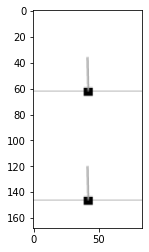

In [7]:
env.reset()
inp_img = None
for i in range(2):
    gray_scale = cv2.cvtColor(env.render("rgb_array"), cv2.COLOR_RGB2GRAY)
    gray_scale_cropped = cv2.resize(gray_scale, (84, 84), interpolation=cv2.INTER_AREA)

    if inp_img is None:
        inp_img = gray_scale_cropped
    else:
        inp_img = np.vstack((inp_img, gray_scale_cropped))
    
    env.step(env.action_space.sample())
    
plt.imshow(inp_img, cmap="gray")
env.close()

In [8]:
# torch.flatten(torch.from_numpy(gray_scale_cropped)).shape, 84*84
# torch.from_numpy(gray_scale_cropped)
torch.Tensor(inp_img).shape

torch.Size([168, 84])

In [9]:
class DQN(nn.Module):
    
    def __init__(self, width, height):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, )
        
        self.fc1 = nn.Linear(in_features=width*height, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

#         self.fc1 = nn.Linear(in_features=width*height, out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=128)
#         self.out = nn.Linear(in_features=128, out_features=3)
        
    def forward(self, t):
        # expect shape with (batch_size, width, height)
        t = t.reshape(t.shape[0], -1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.out(t))
        return t

In [10]:
network = DQN(84, 84*2)
network(torch.from_numpy(inp_img.astype(np.float32)).unsqueeze(0))

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

In [11]:
class Experiance:
    
    def __init__(self, action, state, new_state, reward, done):
        self.action = action
        self.state = state
        self.new_state = new_state
        self.reward = reward
        self.done = done

In [12]:
Experiance(1, 2, 3, 4, 5)

In [13]:
@dataclass(init=True, repr=False)
class ReplayMemory:
    
    """
        ReplayMemory class is for handling the replay memory data and sample batch_size samples for training.
    """
    
    capacity: int
    memory: list = field(default_factory=list)
    push_count: int = 0
        
    def push(self, exp):
        if len(self.memory) < self.capacity:
            self.memory.append(exp)
        else:
            self.memory[self.push_count % self.capacity] = exp
        self.push_count += 1
        
    def sample(self, batch_size):
        return [self.memory[i] for i in np.random.permutation(len(self.memory))[:batch_size]]
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [14]:
@dataclass(init=True)
class EpGreedy:
    
    start: int
    end: int
    decay: int
        
    def get_exploration_rate(self, current_step):
#         if current_step - self.decay >= self.end:
#             return current_step - self.decay
#         return current_step
        return self.end + (self.start - self.end) * np.exp(-1 * current_step * self.decay)

In [15]:
ep_greedy = EpGreedy(1, 0.2, 0.001)

In [16]:
ep_greedy.get_exploration_rate(300)

0.7926545765453743

**RL Agent**

In [17]:
class Agent:
    
    def __init__(self, strategy, num_actions):
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return np.random.choice(self.num_actions) # explore
        else:
            with torch.no_grad():
#                 print(policy_net(state.unsqueeze(0)).argmax().item())
                return policy_net(state.unsqueeze(0)).argmax().item() # exploit

In [18]:
car_env = gym.make('MountainCar-v0').unwrapped
car_env.action_space.n

3

In [19]:
# car_env.reset()
# inp_img = None
# for i in range(2):
#     gray_scale = cv2.cvtColor(car_env.render("rgb_array"), cv2.COLOR_RGB2GRAY)
#     gray_scale_cropped = cv2.resize(gray_scale, (100, 100), interpolation=cv2.INTER_AREA)

#     if inp_img is None:
#         inp_img = gray_scale_cropped
#     else:
#         inp_img = np.vstack((inp_img, gray_scale_cropped))
    
#     env.step(car_env.action_space.sample())
    
# plt.imshow(inp_img, cmap="gray")
# car_env.close()

In [20]:
class EnvManager:
    
    def __init__(self):
        self.env = gym.make('CartPole-v0').unwrapped
        self.agent = Agent(EpGreedy(1, 0.01, 0.001), self.env.action_space.n)
        self.width = 84
        self.height = 84
        self.stack_size = 4
        self.discount_factor = 0.98
        self.policy_network = DQN(self.width, self.height*self.stack_size)
        self.target_network = DQN(self.width, self.height*self.stack_size)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=0.001)
        memory_size = 100000
        self.replay_memory = ReplayMemory(memory_size)
        
    def get_screen_tensor(self):
        gray_scale = cv2.cvtColor(self.env.render("rgb_array"), cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray_scale, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
        return torch.from_numpy(resized.astype(np.float32))

    def stack_experiences(self, experiences):
        actions = []
        states = []
        new_states = []
        rewards = []
        done = []
        
        for exp in experiences:
            actions.append(exp.action)
            states.append(exp.state)
            new_states.append(exp.new_state)
            rewards.append(exp.reward)
            done.append(exp.done)
            
#         print(len(actions), len(states), len(new_states), len(rewards))
    
        return torch.tensor(actions), torch.stack(states), torch.stack(new_states), torch.tensor(rewards), torch.tensor(done)
    
    def replay_memory_gradient_descent(self, batch_size):
        
        if self.replay_memory.can_provide_sample(batch_size):
            experiences = self.replay_memory.sample(batch_size)

            actions, states, new_states, rewards, done = self.stack_experiences(experiences)
#             print(done)
            optimal_q_values = self.policy_network(new_states).max(dim=1)[0]

#             for i, d in enumerate(done):
#                 if d == True:
#                     optimal_q_values[i] = 0
            
            q_values = em.policy_network(states).gather(1, actions.reshape(-1, 1)).flatten()
            # print("q_values", optimal_q_values - q_values)
            loss = F.mse_loss(q_values, optimal_q_values)
#             loss = torch.sum((optimal_q_values - q_values) ** 2)

            print("loss", loss)
            self.optimizer.zero_grad()
            loss.backward()
#             print("asdasd")
#             total_loss += loss.item()

            self.optimizer.step()
                
#             print("total loss", total_loss)


    def train_algorithm(self):

        episodes = 1000
        max_steps = 100
        batch_size = 256
        target_update = 10
        
        duration = []

        # episodes
        for ep in range(episodes):

            print(f"********Ep {ep+1}********")

            total_reward = 0

            self.env.reset()
            
            stack_tensors = []
            
            for step in range(max_steps):
#                 print(f"Step {step+1}")
                
                if len(stack_tensors) != self.stack_size:
                    stack_tensors.append(self.get_screen_tensor())
                    self.env.step(self.env.action_space.sample())
#                     print("backup")
                    continue
                    
                current_input = torch.vstack(stack_tensors)
                action = self.agent.select_action(current_input, self.policy_network)
                
                observation, reward, done, info = self.env.step(action)
                
                if done:
                    reward = -1
                
                stack_tensors.pop(0)
                
#                 if not done:
                stack_tensors.append(self.get_screen_tensor())
#                 else:
#                     stack_tensors = [
#                         torch.zeros_like(stack_tensors[0])
#                         for i in range(self.stack_size)
#                     ]
                next_input = torch.vstack(stack_tensors)
                
                # debugging
#                 plt.figure(figsize=(12, 25))
#                 print(current_input.shape, next_input.shape)
#                 plt.imshow(torch.vstack((current_input, next_input)), cmap="gray")
#                 plt.imshow(next_input, cmap="gray")
#                 display(plt.show())
#                 pdb.set_trace()

                total_reward += reward
                
                self.replay_memory.push(Experiance(action, current_input, next_input, reward, done))
                
                self.replay_memory_gradient_descent(batch_size)
                
#                 with torch.no_grad():
#                     optimal_q_value = reward + self.discount_factor * self.policy_network(next_input).max().item()
#                     q_value = self.policy_network(current_input)[action].item()
#                     loss = (optimal_q_value - q_value) ** 2
#                     total_loss += loss
                    
                current_input = next_input.clone().detach()
                
#                 print("total reward", total_reward)
#                 print("total loss", total_loss)
                
                if done:
                    break
            
            duration.append(step)
            print("total reward", total_reward)
            print("Exp rate", self.agent.strategy.get_exploration_rate(self.agent.current_step))
            
            clear_output(wait=True)
            plt.plot(duration)
            display.display(plt.show())
            
            if ep % target_update == 0:
                self.target_network.load_state_dict(self.policy_network.state_dict())
            
        self.env.close()
        
    def safe_train(self):
        try:
            self.train_algorithm()
        except:
            self.env.close()

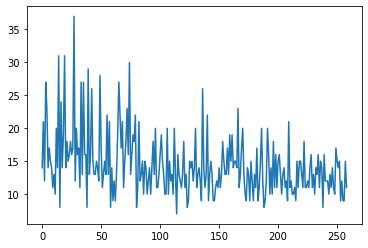

None

********Ep 260********
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)
loss tensor(0., grad_fn=<MseLossBackward0>)


In [21]:
em = EnvManager()
em.safe_train()